<a href="https://colab.research.google.com/github/raniaAprilia/cp1/blob/main/dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [1]:
import os
from google.colab import files

In [2]:
upload = files.upload()

Saving face-shape-dataset-metadata.json to face-shape-dataset-metadata.json


In [3]:
if not os.path.exists('/root/.kaggle'):
  os.makedirs('/root/.kaggle')

!mv face-shape-dataset-metadata.json /root/.kaggle/
!chmod 600 /root/.kaggle/face-shape-dataset-metadata.json

In [4]:
!kaggle datasets download -d niten19/face-shape-dataset

Dataset URL: https://www.kaggle.com/datasets/niten19/face-shape-dataset
License(s): CC0-1.0
 99% 632M/639M [00:09<00:00, 86.9MB/s]
100% 639M/639M [00:09<00:00, 69.5MB/s]


In [5]:
!unzip face-shape-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (161).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (163).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (189).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (192).jpg  
  inflating:

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
from sklearn.model_selection import train_test_split

In [7]:
train_dir = '/content/FaceShape Dataset/training_set'
test_dir = '/content/FaceShape Dataset/testing_set'
val_dir = '/content/FaceShape Dataset/validation_set'
if not os.path.exists('/content/FaceShape Dataset/validation_set'):
  os.makedirs(val_dir, exist_ok=True)

In [8]:
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

for class_dir in class_dirs:
  train_class_dir = os.path.join(train_dir, class_dir)
  val_class_dir = os.path.join(val_dir, class_dir)
  os.makedirs(val_class_dir, exist_ok=True)

  files = os.listdir(train_class_dir)
  train_files, val_files = train_test_split(files, test_size = 0.2, random_state=42)

  for file in val_files:
    src_path = os.path.join(train_class_dir, file)
    dst_path = os.path.join(val_class_dir, file)
    shutil.move(src_path, dst_path)

In [9]:
!find '/content/FaceShape Dataset/training_set' -type f | wc -l
!find '/content/FaceShape Dataset/testing_set' -type f | wc -l
!find '/content/FaceShape Dataset/validation_set' -type f | wc -l

3201
1001
800


## Preprocessing

In [10]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
img_height, img_width = 224, 224

datagen = ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 20,
    width_shift_range= 0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size=32
class_mode ='categorical'

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size= batch_size,
    class_mode = class_mode
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode
)

# Generate preprocessed batches of image data for validation
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode
)

Found 3200 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


In [12]:
print(train_generator.class_indices)

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}


In [19]:
dataset_dir = train_dir

images = []
labels = []
target_size = (224, 224)

for dirname in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, dirname)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                image_path = os.path.join(class_dir, filename)
                try:
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, target_size)
                    images.append(image)
                    labels.append(dirname)
                except (cv2.error, ValueError) as e:
                    print(f"Skipping corrupted image: {image_path}")

images = np.array(images)
labels = np.array(labels)

Skipping corrupted image: /content/FaceShape Dataset/training_set/Oblong/oblong (724).jpg


Label: Round


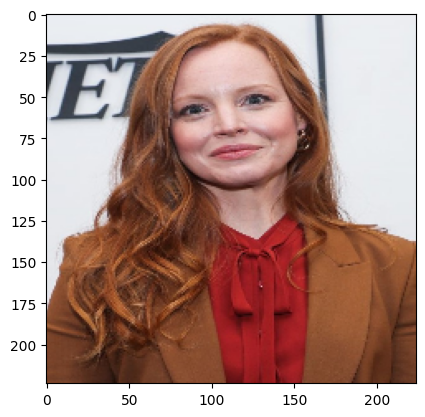

In [20]:
if len(images) > 0:
    # Choose a random index from the arrays
    random_index = np.random.randint(0, len(images))

    # Print the label and display the image
    print(f"Label: {labels[random_index]}")
    plt.imshow(images[random_index])
    plt.show()
else:
  print("No images found in the dataset directory.")

In [21]:
np.save('images_train.npy', images)
np.save('labels_train.npy', labels)

In [22]:
images_train = np.load('images_train.npy')
labels_train=np.load('labels_train.npy')
images_test = np.load('images_test.npy')
labels_test = np.load('labels_test.npy')
images_val = np.load('images_val.npy')
labels_val = np.load('labels_val.npy')

## Detect Face Image


In [23]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.6 MB/s eta 0:00:00


In [24]:
from mtcnn import MTCNN
# Load datasets

images_train = np.load('images_train.npy')
images_test = np.load('images_test.npy')
images_val = np.load('images_val.npy')

# Destination directories
train_destination_directory = './train_faces'
test_destination_directory = './test_faces'
val_destination_directory = './val_faces'

# Create destination directories if they don't exist
os.makedirs(train_destination_directory, exist_ok=True)
os.makedirs(test_destination_directory, exist_ok=True)
os.makedirs(val_destination_directory, exist_ok=True)

# Initialize MTCNN detector
mtcnn = MTCNN()

def detect_and_save_faces(images, destination_directory, dataset_name):
    for idx, image in enumerate(images):
        try:
            faces = mtcnn.detect_faces(image)
        except Exception as e:
            print(f"Error detecting faces in {dataset_name} image {idx}: {e}")
            continue  # Skip this image and move to the next

        if len(faces) > 0:
            largest_face = max(faces, key=lambda f: f['box'][2] * f['box'][3])
            x, y, w, h = largest_face['box']

            min_face_size = 50
            if w > min_face_size and h > min_face_size:
                face = image[y:y+h, x:x+w]

                extracted_face_filename = f'{dataset_name}_{idx}_face.jpg'
                extracted_face_path = os.path.join(destination_directory, extracted_face_filename)

                cv2.imwrite(extracted_face_path, face)
            else:
                print(f"Face in {dataset_name} image {idx} is too small and will be skipped.")
        else:
            print(f"No face detected in {dataset_name} image {idx}.")

# Detect and save faces for each dataset
detect_and_save_faces(images_train, train_destination_directory, 'train')
detect_and_save_faces(images_test, test_destination_directory, 'test')
detect_and_save_faces(images_val, val_destination_directory, 'val')

print("Face extraction complete.")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 52ms/step
Face in val image 623 is too small and will be skipped.
1/1 [==============================] - 0s 61ms/step
Face extraction complete.


In [44]:
import numpy as np

# Measured original skin tone values
original_skin_tone = np.array([[197, 156, 134],  # RGB values for sample 1
                              [210, 168, 144],  # RGB values for sample 2
                              [205, 163, 139]])  # RGB values for sample 3

# Target skin tone values
target_skin_tone = np.array([[200, 160, 140]])  # Desired RGB values for the target skin tone

# Calculate the color correction matrix
original_skin_tone_mean = np.mean(original_skin_tone, axis=0)
target_skin_tone_mean = np.mean(target_skin_tone, axis=0)

correction_matrix = np.diag(target_skin_tone_mean / original_skin_tone_mean)

Random samples from training dataset:


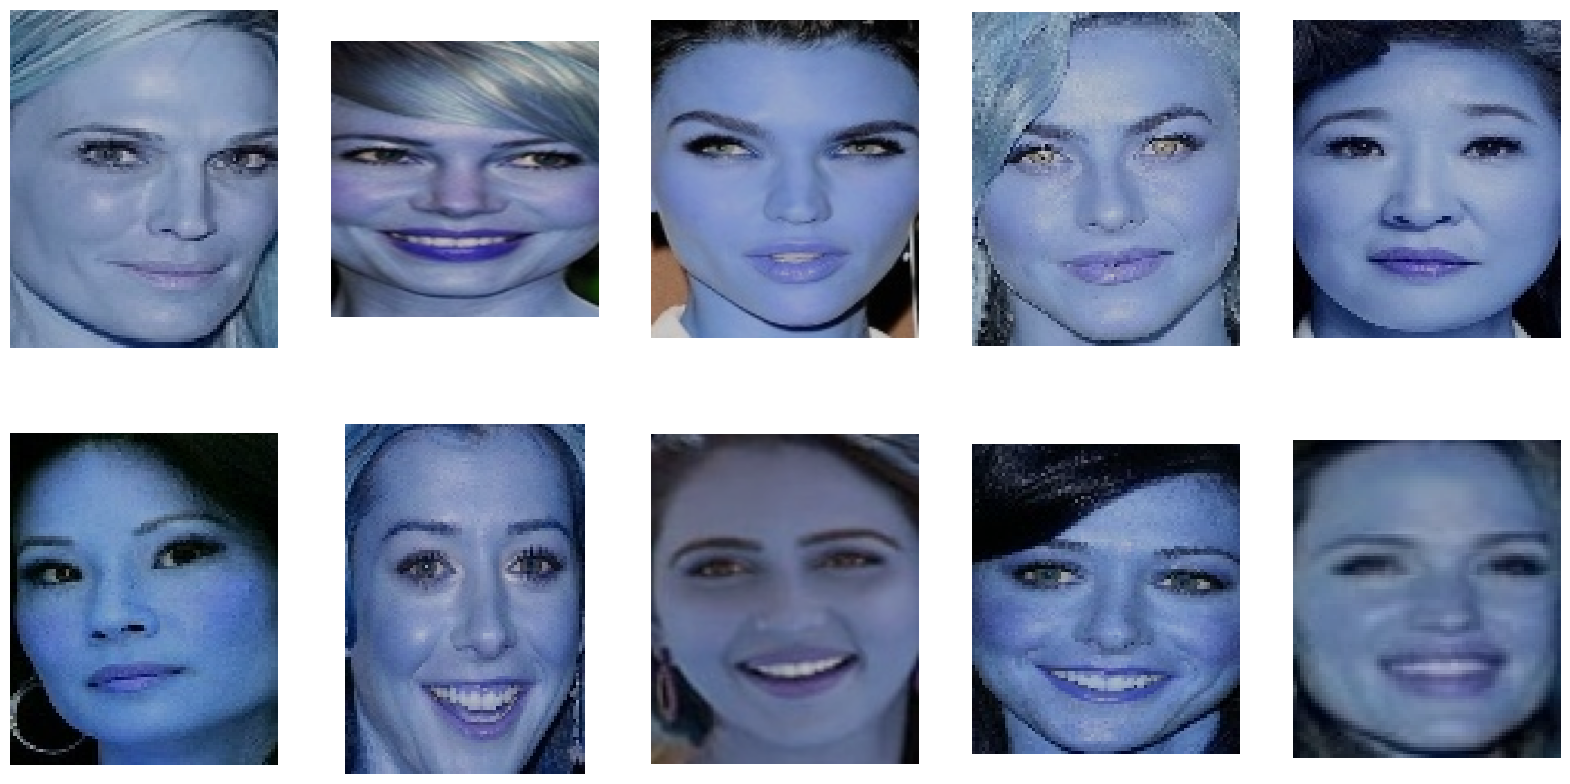

Random samples from test dataset:


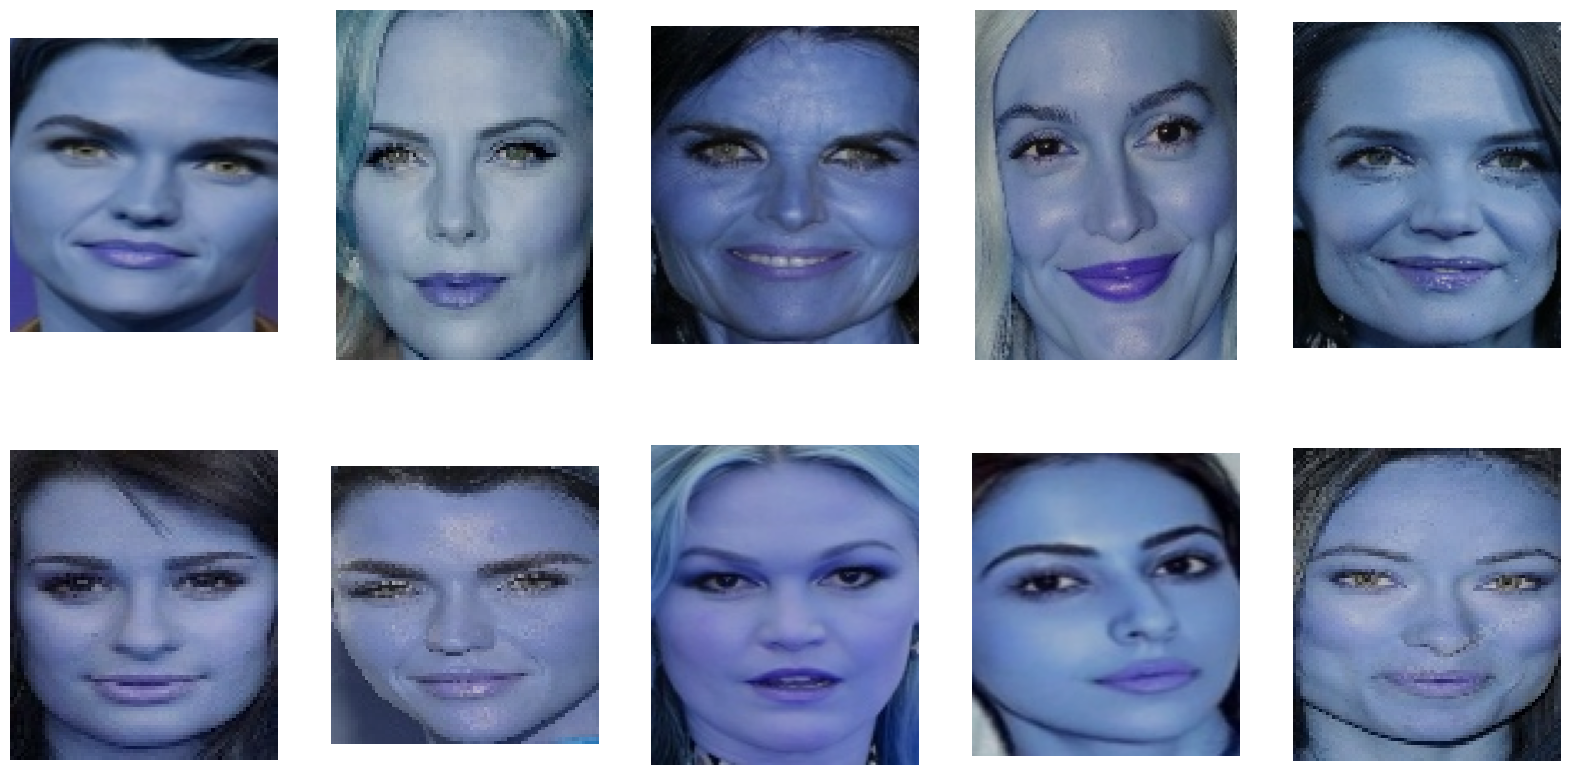

Random samples from validation dataset:


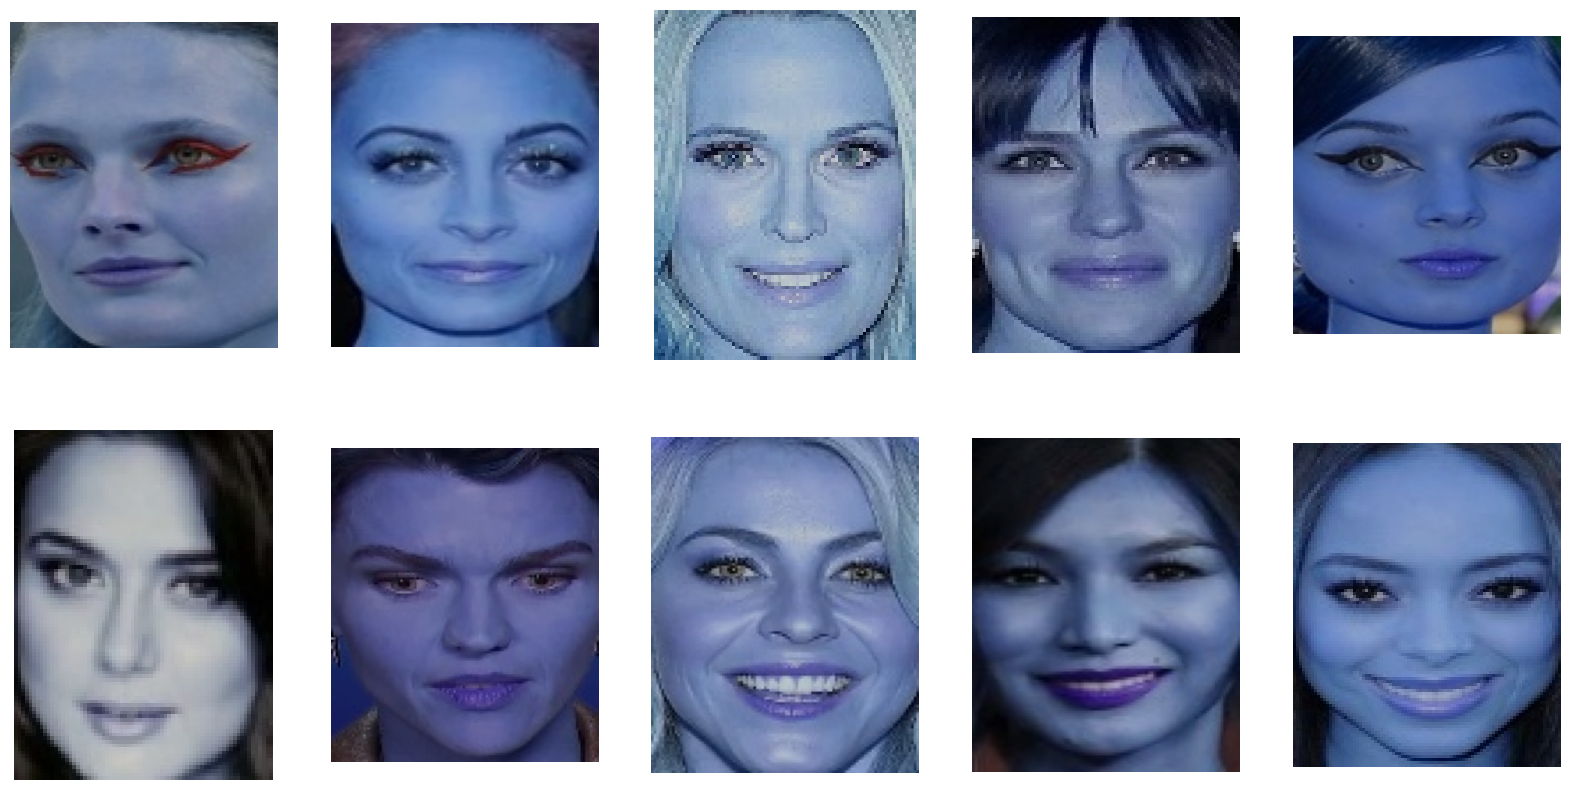

In [45]:
import os
import cv2
import matplotlib.pyplot as plt

def restore_image_color(image_path):
    """
    Restore the original color of an image.

    Args:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray: The image with restored color.
    """
    # Load the image
    img = cv2.imread(image_path)

    # Check if the image was successfully loaded
    if img is None:
        print(f"Error reading image: {image_path}")
        return None

    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply color correction
    img_corrected = cv2.transform(img_rgb, np.array([[.8, 0.0, 0.0],
                                                    [0.0, 0.8, 0.0],
                                                    [0.0, 0.0, .8]]))

    return img_corrected

def show_random_samples(images_dir, sample_size=10):
    # Get list of image file paths in the directory
    image_paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Ensure there are enough images to sample
    if len(image_paths) < sample_size:
        print(f"Not enough images in {images_dir} to sample {sample_size} images.")
        return

    # Select random sample images
    sample_indices = random.sample(range(len(image_paths)), sample_size)
    sample_images = [image_paths[i] for i in sample_indices]

    # Plot sample images
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(sample_images):
        # Restore the original color of the image
        img_corrected = restore_image_color(img_path)

        if img_corrected is not None:
            plt.subplot(2, 5, i + 1)
            plt.imshow(img_corrected)
            plt.axis('off')
        else:
            print(f"Error processing image: {img_path}")

    plt.show()

# Show random sample images from each dataset
print("Random samples from training dataset:")
show_random_samples(train_destination_directory)

print("Random samples from test dataset:")
show_random_samples(test_destination_directory)

print("Random samples from validation dataset:")
show_random_samples(val_destination_directory)

## Labelling skintone


In [ ]:
skin_tone_labels = {
    "beige": ((180, 150, 150), (210, 190, 230)),
    "fair": ((170, 140, 140), (200, 180, 220)),
    "light": ((150, 120, 120), (180, 160, 200)),
    "tan": ((120, 90, 90), (160, 130, 180)),
    "olive": ((80, 60, 60), (140, 100, 160))

}

In [ ]:
def get_skin_tone_label(average_color, skin_tone_labels):
  for label, (lower, upper) in skin_tone_labels.items():
    if all(lower[i] <= average_color[i] <= upper[i] for i in range(3)):
      return label
  return "unknown"
for i in range(5):
    skin, _ = extract_skin_regions(images_train[i])
    average_color = get_average_skin_color(skin)
    label = get_skin_tone_label(average_color, skin_tone_labels)
    print(f"Image {i} Label: {label}, Average Color (BGR): {average_color}")

Image 0 Label: unknown, Average Color (BGR): [0 0 0]
Image 1 Label: unknown, Average Color (BGR): [167.04912281 171.54035088 200.83157895]
Image 2 Label: unknown, Average Color (BGR): [47.22537151 59.64627919 93.2717884 ]
Image 3 Label: unknown, Average Color (BGR): [178.73319545 194.29899173 213.12771458]
Image 4 Label: unknown, Average Color (BGR): [64.42857143 68.39285714 71.25      ]


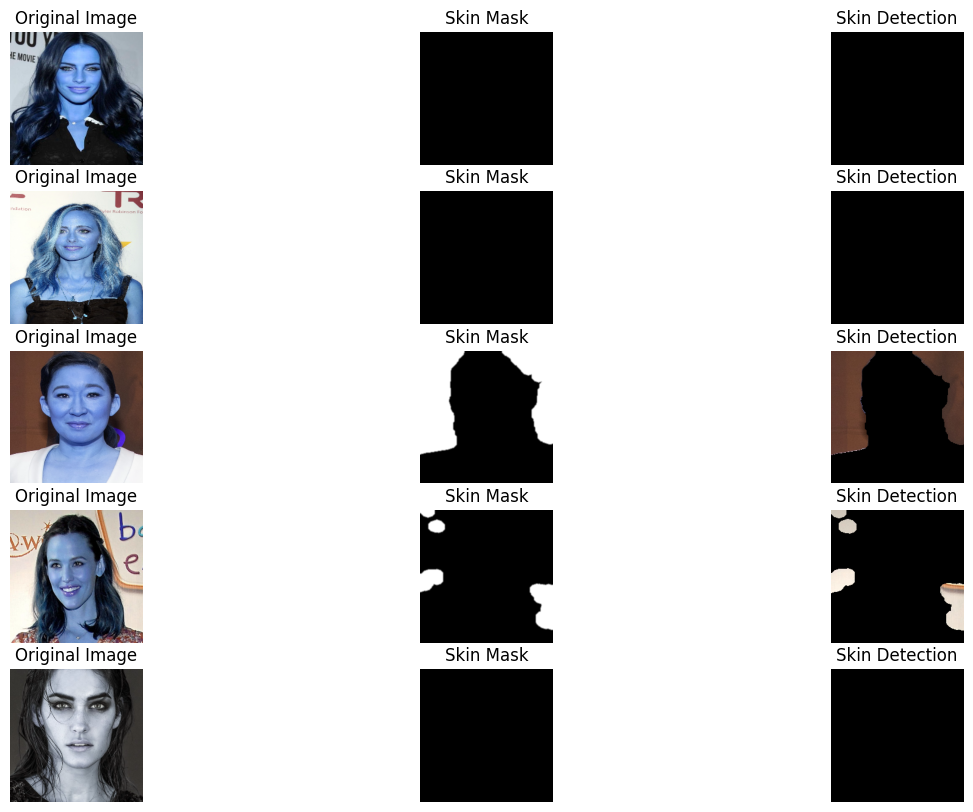

In [ ]:
def extract_skin_region(image):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  lower_skin = np.array([0,20,70],dtype=np.uint8)
  upper_skin = np.array([20, 255, 255], dtype = np.uint8)

  skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

  skin = cv2.bitwise_and(image, image, mask = skin_mask)

  return

In [ ]:
def get_average_skin_color(skin):
    skin_pixels = skin.reshape(-1, 3)
    skin_pixels = skin_pixels[np.any(skin_pixels > 0, axis=1)]  # Remove black pixels

    if len(skin_pixels) > 0:
        return np.mean(skin_pixels, axis=0)
    else:
        return np.array([0, 0, 0])

def label_dataset(images, skin_tone_labels):
    labels = []
    for image in images:
        skin = extract_skin_regions(image)
        average_color = get_average_skin_color(skin)
        label = get_skin_tone_label(average_color, skin_tone_labels)
        labels.append(label)
    return labels

In [ ]:
def display_images_with_labels(images, labels, num_images=10):
    # Number of images to display
    num_images = min(num_images, len(images))

    # Create a figure to display the images
    plt.figure(figsize=(20, 10))

    for i in range(num_images):
        image = images[i]
        label = labels[i]

        # Display image
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Skin Tone: {label}")
        plt.axis('off')

    plt.show()

In [ ]:
images_train = np.load('images_train.npy')
images_test = np.load('images_test.npy')
images_val = np.load('images_val.npy')

In [ ]:
train_labels = label_dataset(images_train, skin_tone_labels)
test_labels = label_dataset(images_test, skin_tone_labels)
val_labels = label_dataset(images_val, skin_tone_labels)


In [ ]:
np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)
np.save('val_labels.npy', val_labels)

Training Dataset


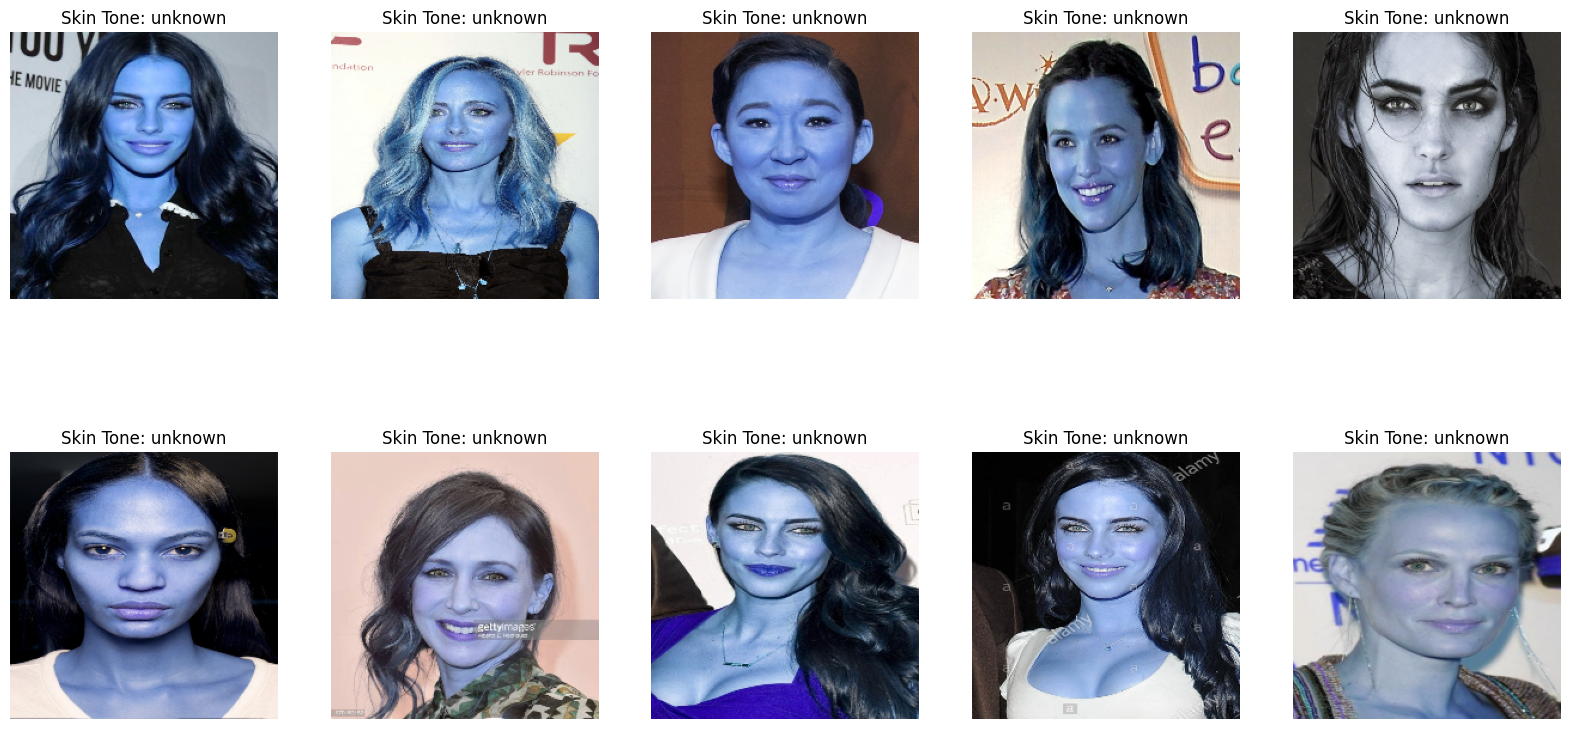

Test Dataset


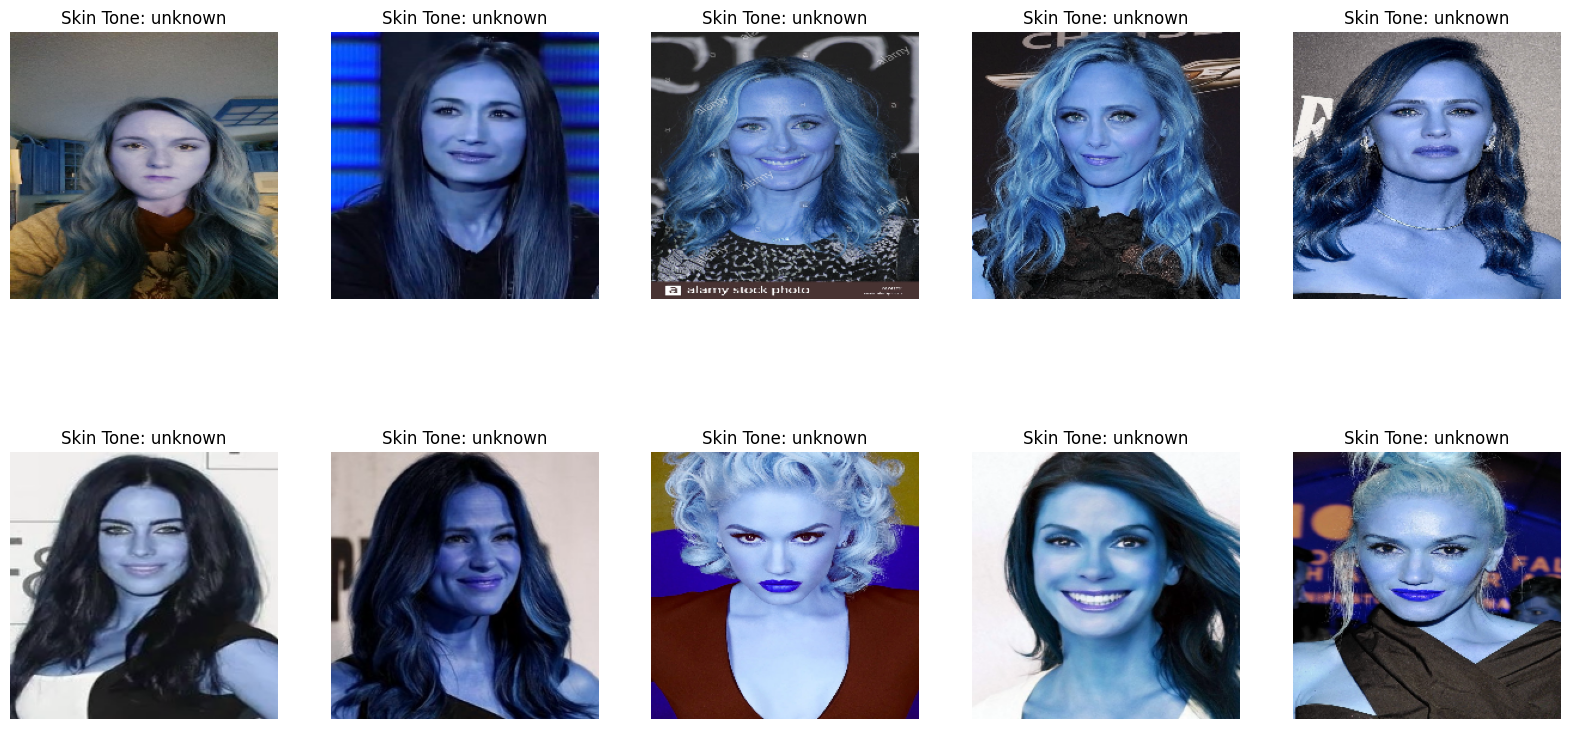

Validation Dataset


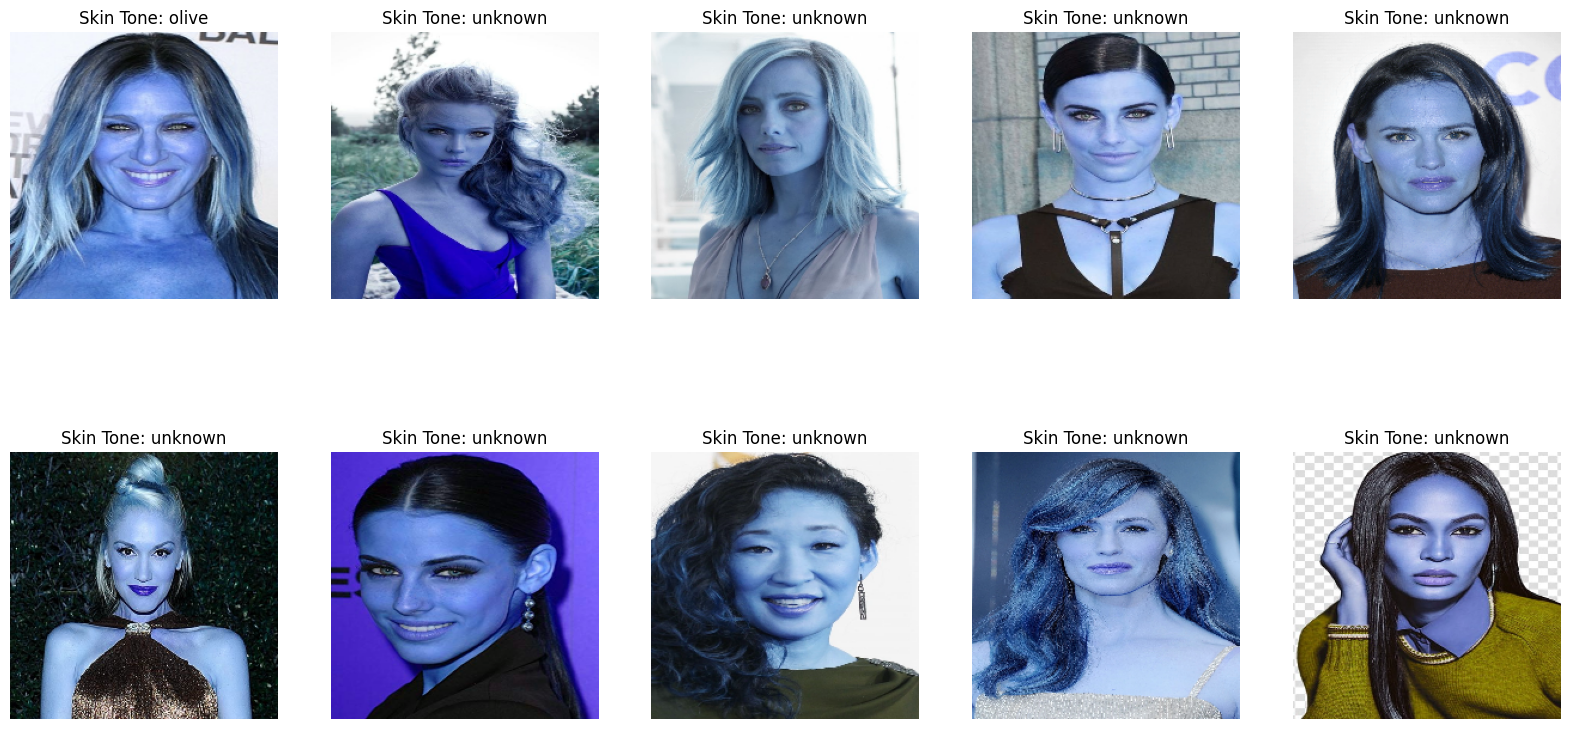

In [ ]:
# Visualize a subset of the training dataset
print("Training Dataset")
display_images_with_labels(images_train, train_labels, num_images=10)

# Visualize a subset of the test dataset
print("Test Dataset")
display_images_with_labels(images_test, test_labels, num_images=10)

# Visualize a subset of the validation dataset
print("Validation Dataset")
display_images_with_labels(images_val, val_labels, num_images=10)

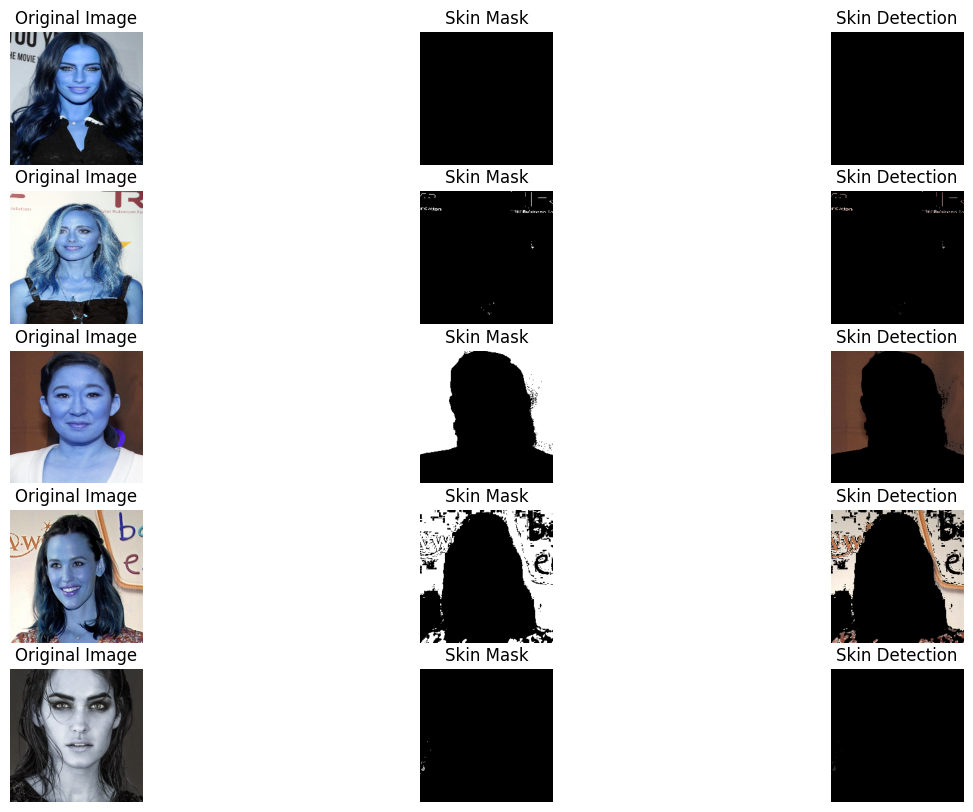

In [ ]:
def extract_skin_regions(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the skin color range in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Create a binary mask where skin color is white
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Apply the mask to extract the skin region
    skin = cv2.bitwise_and(image, image, mask=skin_mask)

    return skin, skin_mask

def display_skin_detection(images, num_images=5):
    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        image = images[i]
        skin, skin_mask = extract_skin_regions(image)

        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(skin_mask, cmap='gray')
        plt.title("Skin Mask")
        plt.axis('off')

        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
        plt.title("Skin Detection")
        plt.axis('off')

    plt.show()

# Load the images
images_train = np.load('images_train.npy')

# Display skin detection results for a few images
display_skin_detection(images_train, num_images=5)


In [ ]:
def get_average_skin_color(skin):
    skin_pixels = skin.reshape(-1, 3)
    skin_pixels = skin_pixels[np.any(skin_pixels > 0, axis=1)]  # Remove black pixels

    if len(skin_pixels) > 0:
        return np.mean(skin_pixels, axis=0)
    else:
        return np.array([0, 0, 0])  # Default color if no skin pixels found

for i in range(5):
    skin, _ = extract_skin_regions(images_train[i])
    average_color = get_average_skin_color(skin)
    print(f"Image {i} Average Skin Color (BGR): {average_color}")


Image 0 Average Skin Color (BGR): [0 0 0]
Image 1 Average Skin Color (BGR): [167.04912281 171.54035088 200.83157895]
Image 2 Average Skin Color (BGR): [47.22537151 59.64627919 93.2717884 ]
Image 3 Average Skin Color (BGR): [178.73319545 194.29899173 213.12771458]
Image 4 Average Skin Color (BGR): [64.42857143 68.39285714 71.25      ]
